##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Classify text with BERT

In this notebook, we:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build model by combining BERT with a classifier
- Train model, fine-tuning BERT as part of that
- Save model and use it to classify sentences


## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [5]:
# A dependency of the preprocessing for BERT inputs
%pip install -q -U "tensorflow-text"

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\stlp\\anaconda3\\Lib\\site-packages\\google\\~upb\\_message.pyd'
Consider using the `--user` option or check the permissions.



In [2]:
%pip install -q tf-models-official==2.11.0

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.5.2.52 (from tf-models-official) (from versions: 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72)
ERROR: No matching distribution found for opencv-python-headless==4.5.2.52


In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

ImportError: cannot import name 'builder' from 'google.protobuf.internal' (c:\Users\stlp\anaconda3\lib\site-packages\google\protobuf\internal\__init__.py)

### Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

We'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset


In [ ]:
# Set the URL for the dataset
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

# Download and extract the dataset using Keras' utility function `get_file`
dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

# Define the path to the dataset directory
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

# Define the path to the training data directory
train_dir = os.path.join(dataset_dir, 'train')

# Remove the 'unsup' directory that contains unsupervised data to make loading the data easier
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 6s 0us/step


The provided code snippet is used to prepare the IMDB dataset for sentiment analysis of movie reviews. The text_dataset_from_directory utility is used to create labeled tf.data.Dataset objects for the training, validation, and testing datasets. The batch size is set to 32 and a random seed of 42 is used for consistency in results. The validation_split argument is used to create a validation set from 20% of the training data, and the remaining training data is cached and prefetched using AUTOTUNE for improved performance during training. Similarly, the validation and testing datasets are also cached and prefetched using AUTOTUNE. The class names for the sentiment labels are retrieved from the training dataset. Overall, this code sets up the IMDB dataset for sentiment analysis and optimizes data loading and preprocessing performance using AUTOTUNE.

In [ ]:
# Define the Autotune constant to be used for data loading and preprocessing
AUTOTUNE = tf.data.AUTOTUNE

# Define the batch size used for training the model
batch_size = 32

# Set the random seed to ensure consistency in results across multiple runs of the code
seed = 42

# Load the training data from the directory 'aclImdb/train' using Keras' text_dataset_from_directory function
# Set the batch size and validation split, as well as the subset to use for training
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

# Retrieve the class names from the training dataset
class_names = raw_train_ds.class_names

# Cache and prefetch the training dataset to improve performance during training
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Load the validation dataset from the directory 'aclImdb/train'
# Set the batch size and validation split, as well as the subset to use for validation
val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

# Cache and prefetch the validation dataset to improve performance during validation
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Load the testing dataset from the directory 'aclImdb/test'
# Set the batch size to be used during testing
test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

# Cache and prefetch the testing dataset to improve performance during testing
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2023-03-14 18:36:24.926453: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-14 18:36:24.926535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (STLP-0189): /proc/driver/nvidia/version does not exist
2023-03-14 18:36:24.930931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In this code, we are looping over the first batch of the training dataset using train_ds.take(1). Within this loop, we are then looping over the first 3 reviews in the batch using range(3). For each review, we print out the text using text_batch.numpy()[i], and then get the corresponding label for the review using label_batch.numpy()[i]. Finally, we print out the label value and its corresponding class name using class_names[label].

Note that we are only printing out the first batch of reviews here for demonstration purposes.

In [ ]:
# Loop over the first batch of the training dataset
for text_batch, label_batch in train_ds.take(1):
  # Loop over the first 3 reviews in the batch
  for i in range(3):
    # Print the review text
    print(f'Review: {text_batch.numpy()[i]}')
    # Get the label for the review
    label = label_batch.numpy()[i]
    # Print the label and its corresponding class name
    print(f'Label : {label} ({class_names[label]})')


Review: b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up."
Label : 1 (pos)
Review: b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of mad

2023-03-14 22:28:40.864338: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

We have the option to choose which BERT model we want to load from TensorFlow Hub and fine-tune for our sentiment analysis task. We decided to go with Small BERTs since they have fewer and/or smaller Transformer blocks, making them faster and more memory-efficient to train and deploy. This is particularly useful since our current model is taking 45 minutes per epoch to train, and we have limited computational resources. Additionally, Small BERTs still maintain a good level of performance on NLP tasks like sentiment analysis. The other BERT models available have different trade-offs between speed, size, and quality, and we can choose one of them if we want even better accuracy or have more resources available. All these models can be loaded from their corresponding TensorFlow Hub URLs using the code block provided.

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

The first variable bert_model_name is a string which takes one of the given BERT models as input. The second variable map_name_to_handle is a dictionary which maps each BERT model name to its corresponding TensorFlow Hub URL. The URLs are used to load the pre-trained BERT models using TensorFlow Hub.

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### The preprocessing model

We need to transform text inputs into numeric token ids and arrange them in Tensors before inputting them to BERT. Luckily, TensorFlow Hub provides a matching preprocessing model for each BERT model we choose, which implements this transformation using TF ops from the TF.text library. This means we don't need to run pure Python code outside of our TensorFlow model to preprocess text.

It's important to use the preprocessing model that is referenced in the documentation of the BERT model we choose, which we can find at the URL printed above. If we choose a BERT model from the drop-down above, the preprocessing model will be selected automatically.

Note: To load the preprocessing model into our fine-tuned model, we'll use the hub.KerasLayer API. This is the preferred way to load a TF2-style SavedModel from TF Hub into a Keras model.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

We can try the preprocessing model on some text and observe the output.

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


We can see that we have obtained the 3 outputs from the preprocessing that a BERT model would use (input_words_id, input_mask, and input_type_ids).

It is important to note that the input is truncated to 128 tokens, although the number of tokens can be customized as required.

Also, the input_type_ids only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, we can include it directly in our model.

### Using the BERT model

Now that we have our preprocessed inputs, let's see how we can use the BERT model. We will load the BERT model from TF Hub and examine its outputs.

First, we will load the BERT model from the TF Hub using hub.KerasLayer(). Then, we will pass our preprocessed inputs to the BERT model to get its outputs. The outputs from the BERT model are embeddings for each token in the input sequence, along with a pooled embedding for the entire sequence.

The embeddings for each token can be used for various NLP tasks such as classification, question answering, etc. The pooled embedding is a condensed representation of the entire input sequence that can be used for tasks such as sentence similarity, clustering, etc.

Let's take a closer look at the BERT model outputs and see how we can use them in our downstream tasks.

In [ ]:
# Load the BERT model from TensorFlow Hub using the provided handle and wrap it in a KerasLayer
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
# Pass preprocessed text through the BERT model to get outputs
bert_results = bert_model(text_preprocessed)

# Print information about the BERT model
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626286   0.9928098  -0.18611895  0.36673862  0.15233758  0.655045
  0.96811545 -0.948627    0.00216105 -0.9877731   0.06842747 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946334  0.3432125   0.33231455 ...  0.21300778  0.710208
  -0.05771144]
 [-0.28741926  0.31981003 -0.23018411 ...  0.58455145 -0.21329735
   0.7269199 ]
 [-0.6615691   0.68876886 -0.8743307  ...  0.10877214 -0.26173237
   0.4785539 ]
 ...
 [-0.22561145 -0.28925598 -0.07064315 ...  0.4756602   0.832772
   0.40025413]
 [-0.29824206 -0.2747315  -0.05450486 ...  0.48849693  1.0955367
   0.18163429]
 [-0.44378254  0.00930669  0.07223734 ...  0.17290081  1.1833241
   0.07898083]]


As we have loaded the BERT model and preprocessed our text, we can see the outputs of the BERT model. The BERT model returns a dictionary with three keys: pooled_output, sequence_output, and encoder_outputs.

- pooled_output is the embedding representation of the entire sequence. The shape of this tensor is [batch_size, H], where H is the hidden size of the BERT model.


- sequence_output is the contextual embedding of each token in the input sequence. The shape of this tensor is [batch_size, seq_length, H], where seq_length is the maximum sequence length of the input text.


- encoder_outputs are the intermediate activations of the L transformer blocks, where outputs["encoder_outputs"][i] is a tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L. The last value of the list is equal to sequence_output.
For fine-tuning our BERT model, we will use the pooled_output tensor, which represents the entire sequence as an embedding.

### Define your model

In this step, we are going to define our own fine-tuned model. We will use the text preprocessing model and the BERT model that we loaded in the previous steps, along with a Dense layer and a Dropout layer.

It is important to mention that the preprocessing model we used in the previous step will take care of the inputs and outputs of the BERT model. Therefore, we don't need to worry about it much, but if you need more information about the base model, you can refer to its URL for documentation.

Our model will be very simple but efficient. We will combine the output of the BERT model, which is the pooled_output array, with a Dense layer and a Dropout layer to avoid overfitting.


In [ ]:
# Define a function to build the classifier model
def build_classifier_model():
    
    
  # Define input layer for the text
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  # Load the preprocessing layer from TF Hub
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  # Preprocess the text using the preprocessing layer
  encoder_inputs = preprocessing_layer(text_input)
  # Load the BERT model from TF Hub
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  # Pass the preprocessed inputs through the BERT model
  outputs = encoder(encoder_inputs)
  # Get the pooled output from BERT
  net = outputs['pooled_output']
  # Add a dropout layer
  net = tf.keras.layers.Dropout(0.1)(net)
  # Add a dense layer with sigmoid activation for binary classification
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  # Define the model input and output
  return tf.keras.Model(text_input, net)

Now, we will run the model using the output of the preprocessing model to check if it's working correctly.

First, we will load the build_classifier_model function, which builds the classification model using the BERT encoder.

Then, we will define a sample text and pass it through the preprocessing model.

Finally, we will pass the preprocessed text to the classification model and check if it returns a valid output.

In [ ]:
# create the classifier model
classifier_model = build_classifier_model() 
# obtain the raw output from the BERT model
bert_raw_result = classifier_model(tf.constant(text_test)) 
# apply sigmoid function to the output to obtain the probabilities for the classes
print(tf.sigmoid(bert_raw_result)) 

tf.Tensor([[0.7786666]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

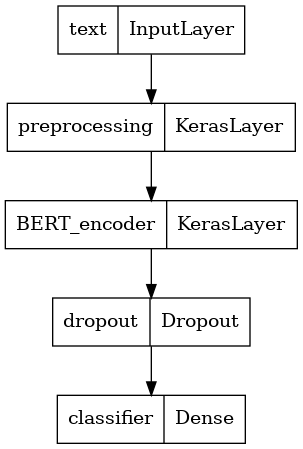

In [ ]:
tf.keras.utils.plot_model(classifier_model)

### Model training

Now that we have all the necessary components such as the preprocessing module, BERT encoder, data, and classifier, we can train the model. Training the model involves the following steps:

- Defining the optimizer, loss function, and evaluation metrics.
- Compiling the model with the optimizer and loss function.
- Fitting the model to the training data with a specified batch size and number of epochs.

The goal of training the model is to update the weights of the neural network such that the loss function is minimized and the evaluation metrics are maximized. Once the model has been trained, we can evaluate its performance on the validation and test sets.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), we'll use `losses.BinaryCrossentropy` loss function.


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

Now that we have our model defined and the optimizer, loss function, and learning rate schedule selected, we can proceed to fine-tune the BERT model.

We will use the model.fit() function in TensorFlow to train the model. The training process will involve passing batches of the preprocessed movie reviews to the model and updating the weights of the model based on the loss calculated by the loss function.

During the training process, we will track the loss and accuracy of the model on both the training and validation sets. This will allow us to monitor the progress of the training and identify any overfitting or underfitting of the model.

We will use early stopping to prevent overfitting. Early stopping will monitor the validation loss and stop the training process if the loss stops improving for a certain number of epochs.

Once the model is trained, we will evaluate its performance on the test set to get an estimate of its real-world performance.


In [ ]:
epochs = 5

# get the number of batches per epoch for the training dataset
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()

# calculate the total number of training steps
num_train_steps = steps_per_epoch * epochs

# calculate the number of warmup steps as 10% of total training steps
num_warmup_steps = int(0.1*num_train_steps)

# set the initial learning rate
init_lr = 3e-5

# create an AdamW optimizer with the specified parameters
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


### Loading the BERT model and training

Using the `classifier_model` we created earlier, you can compile the model with the loss, metric and optimizer.

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 1777s 3s/step - loss: 0.4091 - binary_accuracy: 0.8084 - val_loss: 0.3697 - val_binary_accuracy: 0.8186
Epoch 2/5
625/625 [==============================] - 1919s 3s/step - loss: 0.3025 - binary_accuracy: 0.8686 - val_loss: 0.3706 - val_binary_accuracy: 0.8410
Epoch 3/5
625/625 [==============================] - 1761s 3s/step - loss: 0.2296 - binary_accuracy: 0.9068 - val_loss: 0.3996 - val_binary_accuracy: 0.8480
Epoch 4/5
625/625 [==============================] - 1760s 3s/step - loss: 0.1730 - binary_accuracy: 0.9319 - val_loss: 0.4440 - val_binary_accuracy: 0.8554
Epoch 5/5
625/625 [==============================] - 1759s 3s/step - loss: 0.1406 - binary_accuracy: 0.9456 - val_loss: 0.4980 - val_binary_accuracy: 0.8526


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 700s 895ms/step - loss: 0.4781 - binary_accuracy: 0.8542
Loss: 0.4780920445919037
Accuracy: 0.8541600108146667


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. We can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


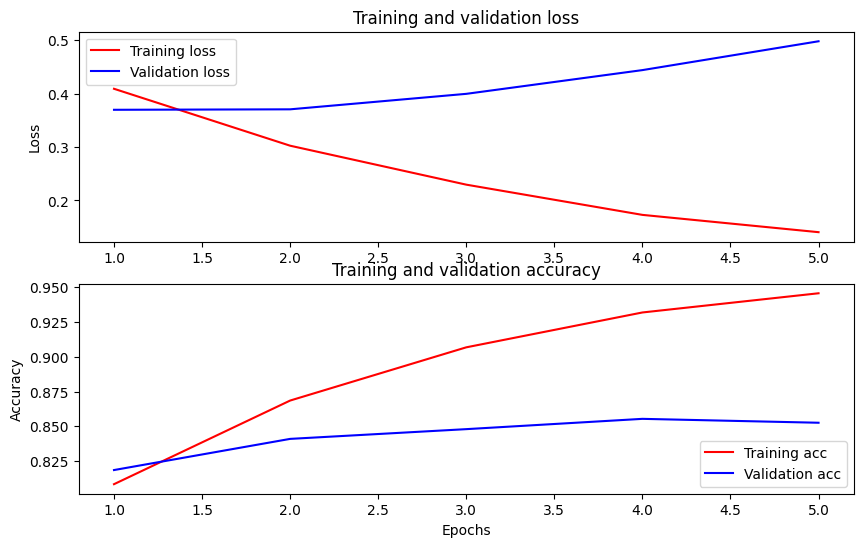

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Save the plots as JPG
plt.savefig('training_and_validation_loss.jpg')
plt.savefig('training_and_validation_accuracy.jpg')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now just save your fine-tuned model for later use.

In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model, so you can try it side by side with the model that is still in memory.

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999686
input: The movie was great!           : score: 0.989988
input: The movie was meh.             : score: 0.585144
input: The movie was okish.           : score: 0.079386
input: The movie was terrible...      : score: 0.000597

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999686
input: The movie was great!           : score: 0.989988
input: The movie was meh.             : score: 0.585144
input: The movie was okish.           : score: 0.079386
input: The movie was terrible...      : score: 0.000597

